In [1]:
import pandas_datareader as web
from datetime import date
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
%matplotlib inline

In [2]:
def get_dates(data_window):
    '''
    Returns the start date and end date for given number of years

    Parameters:
    data_window (int): number of years of past data

    Returns:
    start_date (datetime): start date
    end_date (datetime): today's date
    '''
    end_date = pd.to_datetime(date.today())
    start_date = pd.to_datetime(
        date.today() + relativedelta(years=-data_window))

    return start_date, end_date

In [3]:
# take a look at stock
data_window = 1  # number of years of historical data to look at
start_date, end_date = get_dates(data_window)
stock = 'SPY'  # stock symbol

df = web.DataReader(stock, data_source='yahoo',
                    start=start_date, end=end_date)
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-16,256.899994,237.360001,241.179993,239.850006,297240000.0,235.452972
2020-03-17,256.170013,237.070007,245.039993,252.800003,262070500.0,248.165558
2020-03-18,248.369995,228.020004,236.250000,240.000000,327597100.0,235.600204
2020-03-19,247.380005,232.220001,239.250000,240.509995,289322000.0,236.100845
2020-03-20,244.470001,228.500000,242.529999,228.800003,347158800.0,225.926285
...,...,...,...,...,...,...
2021-03-08,387.679993,381.420013,384.660004,381.720001,122957100.0,381.720001
2021-03-09,389.910004,385.309998,385.850006,387.170013,113457800.0,387.170013
2021-03-10,391.399994,388.170013,389.690002,389.579987,109660800.0,389.579987


In [4]:
# check for null values
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'SPY')

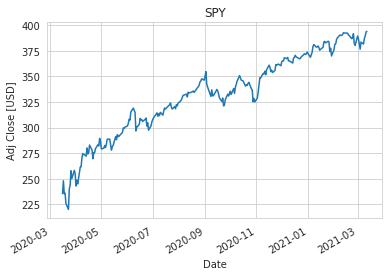

In [5]:
# plot adjusted close
sns.set_style('whitegrid')
df['Adj Close'].plot()
plt.xlabel('Date')
plt.ylabel('Adj Close [USD]')
plt.title(stock)

In [6]:
future_days = 28  # number of days lookahead for future value
# future value is adjusted close future_days into the future
df['Future'] = df['Adj Close'].shift(-future_days)

In [7]:
# take a look at the dataframe now
df

,High,Low,Open,Close,Volume,Adj Close,Future
Date,,,,,,,
2020-03-16,256.899994,237.360001,241.179993,239.850006,297240000.0,235.452972,279.415924
2020-03-17,256.170013,237.070007,245.039993,252.800003,262070500.0,248.165558,283.444672
2020-03-18,248.369995,228.020004,236.250000,240.000000,327597100.0,235.600204,282.141235
2020-03-19,247.380005,232.220001,239.250000,240.509995,289322000.0,236.100845,289.527283
2020-03-20,244.470001,228.500000,242.529999,228.800003,347158800.0,225.926285,286.831604
...,...,...,...,...,...,...,...
2021-03-08,387.679993,381.420013,384.660004,381.720001,122957100.0,381.720001,NaN
2021-03-09,389.910004,385.309998,385.850006,387.170013,113457800.0,387.170013,NaN
2021-03-10,391.399994,388.170013,389.690002,389.579987,109660800.0,389.579987,NaN


In [8]:
# scale the data
cols = list(df.columns)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[cols])

In [9]:
# define features (X) and label (y)
# number of past days of data to use to make prediction future_days ahead
past_days = future_days

X = []
y = []

for i in range(past_days, len(df_scaled) - future_days + 1):
    X.append(df_scaled[i - past_days:i, :-1])
    y.append(df_scaled[i - 1, -1])

In [10]:
# split data into train and test set
X_train = np.array(X[:-future_days])
y_train = np.array(y[:-future_days])
X_test = np.array(X[-future_days:])
y_test = np.array(y[-future_days:])

In [11]:
# reshape labels
y_train = y_train.reshape(y_train.shape[0], 1)
y_test = y_test.reshape(y_test.shape[0], 1)

In [12]:
# build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(
    X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(16))
model.add(Dense(y_train.shape[1]))

In [13]:
# compile model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 28, 64)            18176     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 31,137
Trainable params: 31,137
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit model
history = model.fit(X_train, y_train, epochs=300, batch_size=50, verbose=1)

Epoch 1/300
4/4 [==============================] - 3s 31ms/step - loss: 0.4145
Epoch 2/300
4/4 [==============================] - 0s 30ms/step - loss: 0.0705
Epoch 3/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0621
Epoch 4/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0353
Epoch 5/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0492
Epoch 6/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0331
Epoch 7/300
4/4 [==============================] - 0s 30ms/step - loss: 0.0216
Epoch 8/300
4/4 [==============================] - 0s 35ms/step - loss: 0.0235
Epoch 9/300
4/4 [==============================] - 0s 34ms/step - loss: 0.0201
Epoch 10/300
4/4 [==============================] - 0s 27ms/step - loss: 0.0169
Epoch 11/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0208
Epoch 12/300
4/4 [==============================] - 0s 28ms/step - loss: 0.0195
Epoch 13/300
4/4 [==============================]

In [15]:
# predict on test dataset
y_pred_transformed = model.predict(X_test)

# inverse transform
df_transformed = np.zeros((28, 7))
df_transformed[:, -1] = y_pred_transformed.reshape(y_pred_transformed.shape[0])
y_pred = scaler.inverse_transform(df_transformed)[:, -1]

In [16]:
# store the adjusted close results in a dataframe
results = pd.DataFrame(
    {'Actual': df['Adj Close'].iloc[-future_days:], 'Predicted': y_pred})

# print evaluation metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(
    results['Actual'], results['Predicted']))
print('Mean Squared Error:', metrics.mean_squared_error(
    results['Actual'], results['Predicted']))
print('Root Mean Squared Error:', np.sqrt(
    metrics.mean_squared_error(results['Actual'], results['Predicted'])))

Mean Absolute Error: 6.765719648354077
Mean Squared Error: 60.630012607383584
Root Mean Squared Error: 7.786527634792263


Text(0.5, 1.0, 'SPY (closer look at test data)')

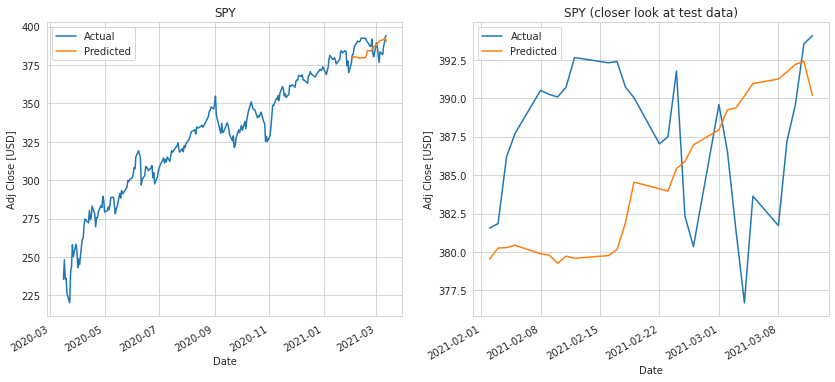

In [17]:
# plot data
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)  # subplot 1
df['Adj Close'].plot(label='Actual')
results['Predicted'].plot(label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Adj Close [USD]')
plt.title(stock)

plt.subplot(1, 2, 2)  # subplot 2 zoomed in
df['Adj Close'].iloc[-y_test.shape[0]:].plot(label='Actual')
results['Predicted'].plot(label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Adj Close [USD]')
plt.title(stock + ' (closer look at test data)')